# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [1]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [3]:
PATH_TO_DATA = "./"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [7]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [9]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 17.4 s, sys: 180 ms, total: 17.6 s
Wall time: 2.1 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [10]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [11]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [12]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [13]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [14]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-11_19-05-52.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [15]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [16]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 2.88 s, sys: 550 ms, total: 3.43 s
Wall time: 13.2 s


In [17]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [18]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [19]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [20]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [21]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

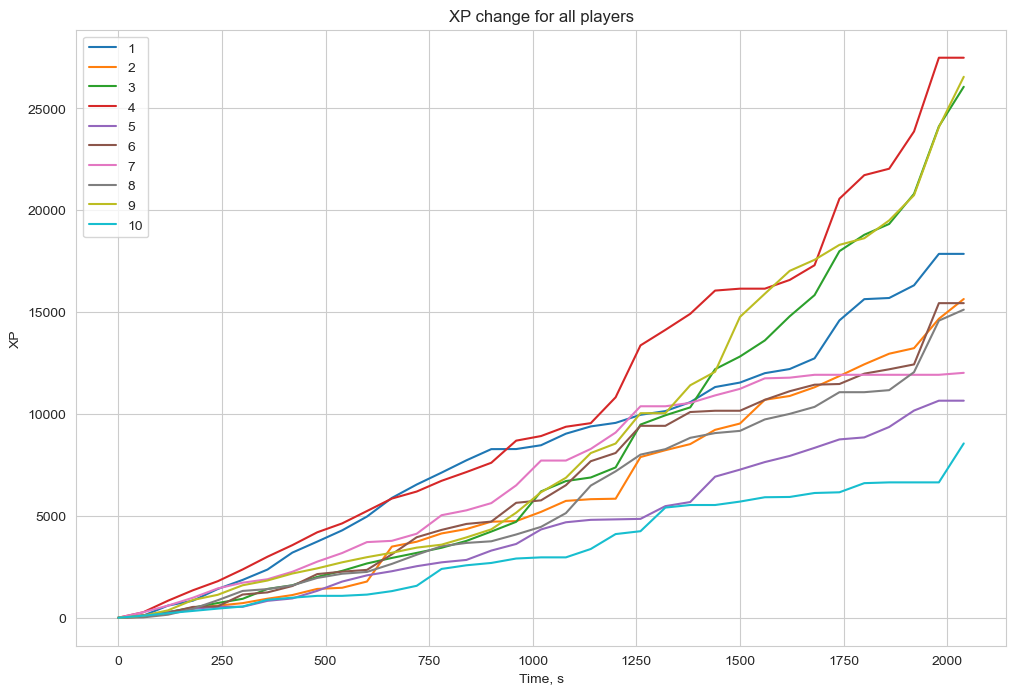

In [22]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [23]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [24]:
def add_new_features(df_features, matches_file):
    """
    Аргументы
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        
        
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [25]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [26]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [27]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 34.8 ms, sys: 36.1 ms, total: 70.9 ms
Wall time: 19.1 s


In [28]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

In [29]:
df_train_features.dtypes.value_counts()

int64      215
float64     30
dtype: int64

В датасете присутствуют только признаки с типами int64 и float64

Посмотрим на разные признаки в датасете:

In [30]:
df_train_features[df_train_features.columns[230:245]]

,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,800,446.93793,4,180,176,0.000000,0,0,0,0,0.000000,0,0,0,0
6db558535151ea18ca70a6892197db41,640,446.93793,1,162,162,0.000000,0,0,0,0,0.000000,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,680,278.93777,2,182,174,0.000000,0,0,0,0,0.000000,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,800,626.93810,8,92,172,8.264696,0,0,3,0,0.250000,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,620,434.93793,3,126,126,15.762911,3,1,0,1,0.500000,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2635,1221.93870,25,78,100,0.000000,2,1,17,0,0.390244,2,2,0,0
308faee28efee2e66b39f9f2ba6ea9cf,1275,854.93830,15,182,176,0.000000,6,2,10,0,0.263158,0,0,15,6
6066cc7417b43c749d551e123d00f0c8,1680,614.93810,11,116,140,11.630505,0,0,15,1,0.555556,0,0,0,0


In [31]:
df_train_features['game_mode'].value_counts()

22    25324
4      2877
23     2079
3       948
2       315
5       148
12        5
16        2
Name: game_mode, dtype: int64

In [32]:
df_train_features['lobby_type'].value_counts()

7    21607
0    10091
Name: lobby_type, dtype: int64

#### Смотрим на прочитанный json файл:

In [33]:
match.keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

In [34]:
match

{'game_time': 2049,
 'match_id_hash': '75112757bde649d5cff1c7cd4f1275c6',
 'teamfights': [{'start': 306.755,
   'end': 338.551,
   'last_death': 323.454,
   'deaths': 3,
   'players': [{'deaths_pos': {},
     'ability_uses': {'lich_frost_nova': 2, 'lich_dark_ritual': 1},
     'item_uses': {},
     'killed': {'npc_dota_hero_faceless_void': 114},
     'deaths': 0,
     'buybacks': 0,
     'damage': 383,
     'healing': 0,
     'gold_delta': 336,
     'xp_delta': 440},
    {'deaths_pos': {},
     'ability_uses': {'pudge_meat_hook': 1, 'pudge_rot': 1},
     'item_uses': {'smoke_of_deceit': 1, 'tpscroll': 1},
     'killed': {},
     'deaths': 0,
     'buybacks': 0,
     'damage': 458,
     'healing': 0,
     'gold_delta': -10,
     'xp_delta': 76},
    {'deaths_pos': {},
     'ability_uses': {},
     'item_uses': {},
     'killed': {},
     'deaths': 0,
     'buybacks': 0,
     'damage': 0,
     'healing': 0,
     'gold_delta': 174,
     'xp_delta': 249},
    {'deaths_pos': {},
     'abilit

## Добавление новых признаков

Будем добавлять новые признаки и смотреть на изменение скора:

### KDA

In [35]:
def add_new_features(df_features, matches_file):
    """
    Аргументы
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # Посчитаем KDA
        kda_rad = 0
        kda_dir = 0
        for player in match["players"]:
            k = player['kills']
            d = player['deaths']
            a = player['assists']
            
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                kda_rad += (k+a)/(d+1)
            else:
                kda_dir += (k+a)/(d+1)
                
        df_features.loc[match_id_hash, "KDA_radiant"] = kda_rad
        df_features.loc[match_id_hash, "KDA_dire"] = kda_dir
        df_features.loc[match_id_hash, "KDA_diff"] = kda_rad - kda_dir
                
            
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [36]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [37]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills,KDA_radiant,KDA_dire,KDA_diff
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0,0,2.0,0.0,2.0,20.333333,1.476190,18.857143
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0,0,3,0,0.0,0.0,0.0,6.416667,10.133333,-3.716667
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,0,3,0,0.0,1.0,-1.0,5.428571,11.333333,-5.904762


In [38]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 33.6 ms, sys: 34 ms, total: 67.6 ms
Wall time: 19.2 s


In [39]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.786747627962526


Значение ROC-AUC немного повысилось

### KDA + Damage

In [40]:
def add_new_features(df_features, matches_file):
    """
    Аргументы
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # Посчитаем KDA
        kda_rad = 0
        kda_dir = 0
        for player in match["players"]:
            k = player['kills']
            d = player['deaths']
            a = player['assists']
            
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                kda_rad += (k+a)/(d+1)
            else:
                kda_dir += (k+a)/(d+1)
                
        df_features.loc[match_id_hash, "KDA_radiant"] = kda_rad
        df_features.loc[match_id_hash, "KDA_dire"] = kda_dir
        df_features.loc[match_id_hash, "KDA_diff"] = kda_rad - kda_dir
        
        
        #Damage и damage taken
        diff_damage_rad = 0
        diff_damage_dir = 0
        
        for player in match["players"]:
            
            damages = sum(player['damage'].values())
            damages_taken = sum(player['damage_taken'].values())
            
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                diff_damage_rad += damages - damages_taken
            else:
                diff_damage_dir += damages - damages_taken
                
        df_features.loc[match_id_hash, "Diff_damage_radiant"] = diff_damage_rad
        df_features.loc[match_id_hash, "Diff_damage_dire"] = diff_damage_dir
        df_features.loc[match_id_hash, "Diff_diff_damage"] = diff_damage_rad - diff_damage_dir
                
            
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [41]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [42]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills,KDA_radiant,KDA_dire,KDA_diff,Diff_damage_radiant,Diff_damage_dire,Diff_diff_damage
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,2.0,0.0,2.0,20.333333,1.476190,18.857143,48562.0,22359.0,26203.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,2.0,-2.0,4.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,2529.0,5313.0,-2784.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0,0.0,0.0,0.0,6.416667,10.133333,-3.716667,91331.0,58839.0,32492.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,0.0,1.0,-1.0,5.428571,11.333333,-5.904762,36326.0,42481.0,-6155.0


In [43]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 36.3 ms, sys: 35.1 ms, total: 71.4 ms
Wall time: 19.3 s


In [44]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.7912915246950384


Значение ROC-AUC еще немного повысилось

### KDA + Damage + Purchase

In [45]:
def add_new_features(df_features, matches_file):
    """
    Аргументы
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # Посчитаем KDA, Damage и damage taken, Purchase
        kda_rad = 0
        kda_dir = 0
        
        diff_damage_rad = 0
        diff_damage_dir = 0
        
        purchase_rad = 0
        purchase_dir = 0
        
        for player in match["players"]:
            
            k = player['kills']
            d = player['deaths']
            a = player['assists']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                kda_rad += (k+a)/(d+1)
            else:
                kda_dir += (k+a)/(d+1)
        
        
            damages = sum(player['damage'].values())
            damages_taken = sum(player['damage_taken'].values())
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                diff_damage_rad += damages - damages_taken
            else:
                diff_damage_dir += damages - damages_taken
                
                
            purchases = sum(player['purchase'].values())
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                purchase_rad += purchases
            else:
                purchase_dir += purchases
                
            
                
        df_features.loc[match_id_hash, "KDA_radiant"] = kda_rad
        df_features.loc[match_id_hash, "KDA_dire"] = kda_dir
        df_features.loc[match_id_hash, "KDA_diff"] = kda_rad - kda_dir
        
        
        df_features.loc[match_id_hash, "Diff_damage_radiant"] = diff_damage_rad
        df_features.loc[match_id_hash, "Diff_damage_dire"] = diff_damage_dir
        df_features.loc[match_id_hash, "Diff_diff_damage"] = diff_damage_rad - diff_damage_dir
        
        df_features.loc[match_id_hash, "Purchase_radiant"] = purchase_rad
        df_features.loc[match_id_hash, "Purchase_dire"] = purchase_dir
        df_features.loc[match_id_hash, "Diff_purchases"] = purchase_rad - purchase_dir
                


In [46]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [47]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,diff_tower_kills,KDA_radiant,KDA_dire,KDA_diff,Diff_damage_radiant,Diff_damage_dire,Diff_diff_damage,Purchase_radiant,Purchase_dire,Diff_purchases
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,2.0,20.333333,1.476190,18.857143,48562.0,22359.0,26203.0,107.0,90.0,17.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,2.0,-2.0,4.0,21.0,18.0,3.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.0,0.000000,0.000000,0.000000,2529.0,5313.0,-2784.0,37.0,32.0,5.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0.0,6.416667,10.133333,-3.716667,91331.0,58839.0,32492.0,112.0,96.0,16.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,-1.0,5.428571,11.333333,-5.904762,36326.0,42481.0,-6155.0,83.0,86.0,-3.0


In [48]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 35.6 ms, sys: 32.9 ms, total: 68.4 ms
Wall time: 20.5 s


In [49]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.7944989817479922


Значение ROC-AUC еще немного повысилось

### KDA +  Damage + Purchase + Kills + Rune pickups

In [50]:
def add_new_features(df_features, matches_file):
    """
    Аргументы
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # Посчитаем KDA, Damage и damage taken, Purchase, Kills, Rune_pickups
        kda_rad = 0
        kda_dir = 0
        
        diff_damage_rad = 0
        diff_damage_dir = 0
        
        purchase_rad = 0
        purchase_dir = 0
        
        kills_rad = 0
        kills_dir = 0
        
        rune_pickups_rad = 0
        rune_pickups_dir = 0
        
        for player in match["players"]:
            
            k = player['kills']
            d = player['deaths']
            a = player['assists']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                kda_rad += (k+a)/(d+1)
            else:
                kda_dir += (k+a)/(d+1)
        
        
            damages = sum(player['damage'].values())
            damages_taken = sum(player['damage_taken'].values())
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                diff_damage_rad += damages - damages_taken
            else:
                diff_damage_dir += damages - damages_taken
                
                
            purchases = sum(player['purchase'].values())
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                purchase_rad += purchases
            else:
                purchase_dir += purchases
                
                
            kills = len(player['kills_log'])
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                kills_rad += kills
            else:
                kills_dir += kills
                
                
            runes_pickups = player['rune_pickups']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                rune_pickups_rad += runes_pickups
            else:
                rune_pickups_dir += runes_pickups
                
            
                
        df_features.loc[match_id_hash, "KDA_radiant"] = kda_rad
        df_features.loc[match_id_hash, "KDA_dire"] = kda_dir
        df_features.loc[match_id_hash, "KDA_diff"] = kda_rad - kda_dir
        
        
        df_features.loc[match_id_hash, "Diff_damage_radiant"] = diff_damage_rad
        df_features.loc[match_id_hash, "Diff_damage_dire"] = diff_damage_dir
        df_features.loc[match_id_hash, "Diff_diff_damage"] = diff_damage_rad - diff_damage_dir
        
        df_features.loc[match_id_hash, "Purchase_radiant"] = purchase_rad
        df_features.loc[match_id_hash, "Purchase_dire"] = purchase_dir
        df_features.loc[match_id_hash, "Diff_purchases"] = purchase_rad - purchase_dir
        
        df_features.loc[match_id_hash, "Kills_radiant"] = kills_rad
        df_features.loc[match_id_hash, "Kills_dire"] = kills_dir
        df_features.loc[match_id_hash, "Diff_kills"] = kills_rad - kills_dir
        
        df_features.loc[match_id_hash, "Rune_pickups_radiant"] = rune_pickups_rad
        df_features.loc[match_id_hash, "Rune_pickups_dire"] = rune_pickups_dir
        df_features.loc[match_id_hash, "Diff_rune_pickups"] = rune_pickups_rad - rune_pickups_dir
                



In [51]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [52]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 34.2 ms, sys: 31.9 ms, total: 66.1 ms
Wall time: 19.8 s


In [53]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.7948134756163819


Значение ROC-AUC еще немного повысилось

Добавление новых признаков увеличивает значение ROC-AUC, но не сильно, поэтому я решила подобрать гиперпараметры для модели при помощи GridSearchCV

### GridSearch

In [54]:
# %%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
# rf_model.fit(X_train, y_train)

In [55]:
params = {'n_estimators':[10, 20, 30, 40, 50, 100, 200, 300, 500, 700, 1000, 1200, 1500], # кол-во деревьев в ансамбле
          'max_depth':[3, 5, 7, 10, 15],
          'max_features':[1, 2]}

In [56]:
%%time

rf_model_grid = GridSearchCV(rf_model, params, scoring='roc_auc', n_jobs=-1)
rf_model_grid.fit(X_train, y_train)

CPU times: user 32.1 s, sys: 1.55 s, total: 33.7 s
Wall time: 4min 55s


GridSearchCV(estimator=RandomForestClassifier(max_depth=7, n_estimators=300,
                                              n_jobs=-1, random_state=10801),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 15], 'max_features': [1, 2],
                         'n_estimators': [10, 20, 30, 40, 50, 100, 200, 300,
                                          500, 700, 1000, 1200, 1500]},
             scoring='roc_auc')

In [57]:
rf_model_grid.best_params_

{'max_depth': 15, 'max_features': 2, 'n_estimators': 1500}

In [58]:
rf_model_grid.best_score_

0.7930842082969192

In [59]:
y_pred = rf_model_grid.predict_proba(X_valid)[:, 1]

In [60]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7954431394963921


In [61]:
%%time
rf_model = RandomForestClassifier(n_estimators=1500, max_depth=15, max_features = 2, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 31.1 s, sys: 1.03 s, total: 32.2 s
Wall time: 4.43 s


RandomForestClassifier(max_depth=15, max_features=2, n_estimators=1500,
                       n_jobs=-1, random_state=10801)

### Кросс-валидация

In [62]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [63]:
%%time
rf_model = RandomForestClassifier(n_estimators=1500, max_depth=15, max_features = 2, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 15.1 s, sys: 2.34 s, total: 17.4 s
Wall time: 22.3 s


In [64]:
cv_scores_rf

array([0.79544314, 0.79343988, 0.78568928, 0.79257528, 0.79168135])

In [65]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7917657866272193


### Построение модели с новыми гиперпараметрами:

In [66]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 46.9 ms, sys: 135 ms, total: 181 ms
Wall time: 37.6 s


In [67]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7917657866272193
ROC-AUC на кросс-валидации для новых признаков: 0.7989743521559276


С новыми значениями гиперпараметров значение ROC-AUC на кросс-валидации для базовых признаков стало заметно больше. \
Теперь буду строить модель с обновленными гиперпараметрами.

## Добавление признаков

До этого я добавляла суммарные значения признаков по игрокам каждой команды, но не убирала из датасета исходные признаки.

Сейчас сделаю немного по-другому:

Добавляем соотношения признаков, а сами признаки убираем из датасета, чтобы не было мультиколлинеарности. \
**Соотношения признаков следующие**: подсчитываем значения признаков по игрокам внутри одной команды, суммируем и получаем значение признака для каждой из команды. Далее считаем отношение: **(rad - dir) / (rad + dir)**. \
Таким образом у нас появляется соотношения значений признаков у команд. При этом число **больше 0** говорит о том, что по данному признаку выигрывает команда **radiant**, а значение **меньше 0** - по данному признаку выигрывает команда **dire**. \
Также данные становятся более нормализованными.

После подсчета удаляем 10 колонок со значениями признаков по каждому игроку.

In [68]:
def add_new_features(df_features, matches_file):
    """
    Аргументы
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

                    
        if (radiant_tower_kills + dire_tower_kills) == 0:
            df_features.loc[match_id_hash, "Tower_kills"] = 0
        else:
            df_features.loc[match_id_hash, "Tower_kills"] = (radiant_tower_kills - dire_tower_kills)/(radiant_tower_kills + dire_tower_kills)
        
        
         
        kda_rad = 0
        kda_dir = 0
        
        diff_damage_rad = 0
        diff_damage_dir = 0
        
        purchase_rad = 0
        purchase_dir = 0
        
        kills_rad = 0
        kills_dir = 0
        
        rune_pickups_rad = 0
        rune_pickups_dir = 0
        
        roshans_killed_rad = 0
        roshans_killed_dir = 0
        
        denies_rad = 0
        denies_dir = 0
        
        gold_rad = 0
        gold_dir = 0
        
        lh_rad = 0
        lh_dir = 0
        
        xp_rad = 0
        xp_dir = 0
        
        max_mana_rad = 0
        max_mana_dir = 0
        
        health_rad = 0
        health_dir = 0
        
        max_health_rad = 0
        max_health_dir = 0
        
        stuns_rad = 0
        stuns_dir = 0
        
        creeps_stacked_rad = 0
        creeps_stacked_dir = 0
        
        camps_stacked_rad = 0
        camps_stacked_dir = 0
        
        obs_placed_rad = 0
        obs_placed_dir = 0
        
        sen_placed_rad = 0
        sen_placed_dir = 0
        
        for player in match["players"]:
            
            k = player['kills']
            d = player['deaths']
            a = player['assists']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                kda_rad += (k+a)/(d+1)
            else:
                kda_dir += (k+a)/(d+1)
        
        
            damages = sum(player['damage'].values())
            damages_taken = sum(player['damage_taken'].values())
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                diff_damage_rad += damages - damages_taken
            else:
                diff_damage_dir += damages - damages_taken
                
                
            purchases = sum(player['purchase'].values())
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                purchase_rad += purchases
            else:
                purchase_dir += purchases
                
                
            kills = len(player['kills_log'])
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                kills_rad += kills
            else:
                kills_dir += kills
                
                
            runes_pickups = player['rune_pickups']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                rune_pickups_rad += runes_pickups
            else:
                rune_pickups_dir += runes_pickups
                
                
            roshans = player['roshans_killed']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                roshans_killed_rad += roshans
            else:
                roshans_killed_dir += roshans
                
            
            denies_ = player['denies']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                denies_rad += denies_
            else:
                denies_dir += denies_
                
                
            gold_ = player['gold']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                gold_rad += gold_
            else:
                gold_dir += gold_
                
                
            lh_ = player['lh']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                lh_rad += lh_
            else:
                lh_dir += lh_
                
                
            xp_ = player['xp']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                xp_rad += xp_
            else:
                xp_dir += xp_
                
                
            max_mana_ = player['max_mana']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                max_mana_rad += max_mana_
            else:
                max_mana_dir += max_mana_
                
                
            health_ = player['health']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                health_rad += health_
            else:
                health_dir += health_
                
                
            max_health_ = player['max_health']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                max_health_rad += max_health_
            else:
                max_health_dir += max_health_
                
            
            stuns_ = player['stuns']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                stuns_rad += stuns_
            else:
                stuns_dir += stuns_
                
                
            creeps_stacked_ = player['creeps_stacked']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                creeps_stacked_rad += creeps_stacked_
            else:
                creeps_stacked_dir += creeps_stacked_
                
                
            camps_stacked_ = player['camps_stacked']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                camps_stacked_rad += camps_stacked_
            else:
                camps_stacked_dir += camps_stacked_
                
            
            obs_placed_ = player['obs_placed']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                obs_placed_rad += obs_placed_
            else:
                obs_placed_dir += obs_placed_
                
                
            sen_placed_ = player['sen_placed']
            if (player["player_slot"] >= 0) and (player["player_slot"] < 5): # radiant
                sen_placed_rad += sen_placed_
            else:
                sen_placed_dir += sen_placed_
                
#             firstblood_claimed
            
                
                
        # KDA
        if (kda_rad + kda_dir) == 0:
            df_features.loc[match_id_hash, "KDA"] = 0
        else:
            df_features.loc[match_id_hash, "KDA"] = (kda_rad - kda_dir)/(kda_rad + kda_dir)
  
        
        
        # Damage
        if (diff_damage_rad + diff_damage_dir) == 0:
            df_features.loc[match_id_hash, "Damage"] = 0
        else:
            df_features.loc[match_id_hash, "Damage"] = (diff_damage_rad - diff_damage_dir)/(diff_damage_rad + diff_damage_dir)

        
        
        # Purchase
        if (purchase_rad + purchase_dir) == 0:
            df_features.loc[match_id_hash, "Purchase"] = 0
        else:
            df_features.loc[match_id_hash, "Purchase"] = (purchase_rad - purchase_dir)/(purchase_rad + purchase_dir)
        
        
        # Rune pickups
        if (rune_pickups_rad + rune_pickups_dir) == 0:
            df_features.loc[match_id_hash, "Rune_pickups"] = 0
        else:
            df_features.loc[match_id_hash, "Rune_pickups"] = (rune_pickups_rad - rune_pickups_dir)/(rune_pickups_rad + rune_pickups_dir)

            
        # Roshans killed
        if (roshans_killed_rad + roshans_killed_dir) == 0:
            df_features.loc[match_id_hash, "Roshans_killed"] = 0
        else:
            df_features.loc[match_id_hash, "Roshans_killed"] = (roshans_killed_rad - roshans_killed_dir)/(roshans_killed_rad + roshans_killed_dir)

            
        # Denies
        if (denies_rad + denies_dir) == 0:
            df_features.loc[match_id_hash, "Denies"] = 0
        else:
            df_features.loc[match_id_hash, "Denies"] = (denies_rad - denies_dir)/(denies_rad + denies_dir)
            
            
        # Gold
        if (gold_rad + gold_dir) == 0:
            df_features.loc[match_id_hash, "Gold"] = 0
        else:
            df_features.loc[match_id_hash, "Gold"] = (gold_rad - gold_dir)/(gold_rad + gold_dir)
            
            
        # Lh
        if (lh_rad + lh_dir) == 0:
            df_features.loc[match_id_hash, "LH"] = 0
        else:
            df_features.loc[match_id_hash, "LH"] = (lh_rad - lh_dir)/(lh_rad + lh_dir)
            
        
        # Xp
        if (xp_rad + xp_dir) == 0:
            df_features.loc[match_id_hash, "XP"] = 0
        else:
            df_features.loc[match_id_hash, "XP"] = (xp_rad - xp_dir)/(xp_rad + xp_dir)
            
            
        # Stuns
        if (stuns_rad + stuns_dir) == 0:
            df_features.loc[match_id_hash, "Stuns"] = 0
        else:
            df_features.loc[match_id_hash, "Stuns"] = (stuns_rad - stuns_dir)/(stuns_rad + stuns_dir)
            
            
        # Creeps_stacked
        if (creeps_stacked_rad + creeps_stacked_dir) == 0:
            df_features.loc[match_id_hash, "Creeps_stacked"] = 0
        else:
            df_features.loc[match_id_hash, "Creeps_stacked"] = (creeps_stacked_rad - creeps_stacked_dir)/(creeps_stacked_rad + creeps_stacked_dir)
            
        
        # Camps_stacked
        if (camps_stacked_rad + camps_stacked_dir) == 0:
            df_features.loc[match_id_hash, "Camps_stacked"] = 0
        else:
            df_features.loc[match_id_hash, "Camps_stacked"] = (camps_stacked_rad - camps_stacked_dir)/(camps_stacked_rad + camps_stacked_dir)

            
        # Obs_placed
        if (obs_placed_rad + obs_placed_dir) == 0:
            df_features.loc[match_id_hash, "Obs_placed"] = 0
        else:
            df_features.loc[match_id_hash, "Obs_placed"] = (obs_placed_rad - obs_placed_dir)/(obs_placed_rad + obs_placed_dir)
            
        
        # Sen_placed
        if (sen_placed_rad + sen_placed_dir) == 0:
            df_features.loc[match_id_hash, "Sen_placed"] = 0
        else:
            df_features.loc[match_id_hash, "Sen_placed"] = (sen_placed_rad - sen_placed_dir)/(sen_placed_rad + sen_placed_dir)


In [69]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

### Deleting columns:

In [70]:
for i in range(1, 6):
        df_train_features_extended = df_train_features_extended.drop(columns = [f'r{i}_towers_killed', f'd{i}_towers_killed'])
        df_train_features_extended = df_train_features_extended.drop(columns = [f'r{i}_kills', f'r{i}_deaths', f'r{i}_assists', 
                                    f'd{i}_kills', f'd{i}_deaths', f'd{i}_assists'])
        df_train_features_extended = df_train_features_extended.drop(columns = [f'r{i}_rune_pickups', f'd{i}_rune_pickups'])
        df_train_features_extended = df_train_features_extended.drop(columns = [f'r{i}_roshans_killed', f'd{i}_roshans_killed'])
        df_train_features_extended = df_train_features_extended.drop(columns = [f'r{i}_denies', f'd{i}_denies',
                                                                               f'r{i}_gold', f'd{i}_gold',
                                                                               f'r{i}_lh', f'd{i}_lh',
                                                                               f'r{i}_xp', f'd{i}_xp',
                                                                               f'r{i}_max_mana', f'd{i}_max_mana',
                                                                               f'r{i}_health', f'd{i}_health',
                                                                               f'r{i}_max_health', f'd{i}_max_health',
                                                                               f'r{i}_stuns', f'd{i}_stuns',
                                                                               f'r{i}_creeps_stacked', f'd{i}_creeps_stacked',
                                                                               f'r{i}_camps_stacked', f'd{i}_camps_stacked',
                                                                               f'r{i}_obs_placed', f'd{i}_obs_placed',
                                                                               f'r{i}_sen_placed', f'd{i}_sen_placed'])

In [71]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [72]:
rf_model.fit(df_train_features_extended.values, y)

RandomForestClassifier(max_depth=15, max_features=2, n_estimators=1500,
                       n_jobs=-1, random_state=10801)

In [73]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 34.9 ms, sys: 97.9 ms, total: 133 ms
Wall time: 37.1 s


In [74]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7917657866272193
ROC-AUC на кросс-валидации для новых признаков: 0.8115720366546487


## Test

In [75]:
PATH_TO_DATA = "./"

df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "test_data.csv"), 
                                    index_col="match_id_hash")

In [76]:
# Скопируем таблицу с признаками
df_test_features_extended = df_test_features.copy()

# Добавим новые
add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [77]:
for i in range(1, 6):
        df_test_features_extended = df_test_features_extended.drop(columns = [f'r{i}_towers_killed', f'd{i}_towers_killed'])
        df_test_features_extended = df_test_features_extended.drop(columns = [f'r{i}_kills', f'r{i}_deaths', f'r{i}_assists', 
                                    f'd{i}_kills', f'd{i}_deaths', f'd{i}_assists'])
        df_test_features_extended = df_test_features_extended.drop(columns = [f'r{i}_rune_pickups', f'd{i}_rune_pickups'])
        df_test_features_extended = df_test_features_extended.drop(columns = [f'r{i}_roshans_killed', f'd{i}_roshans_killed'])
        df_test_features_extended = df_test_features_extended.drop(columns = [f'r{i}_denies', f'd{i}_denies',
                                                                               f'r{i}_gold', f'd{i}_gold',
                                                                               f'r{i}_lh', f'd{i}_lh',
                                                                               f'r{i}_xp', f'd{i}_xp',
                                                                               f'r{i}_max_mana', f'd{i}_max_mana',
                                                                               f'r{i}_health', f'd{i}_health',
                                                                               f'r{i}_max_health', f'd{i}_max_health',
                                                                               f'r{i}_stuns', f'd{i}_stuns',
                                                                               f'r{i}_creeps_stacked', f'd{i}_creeps_stacked',
                                                                               f'r{i}_camps_stacked', f'd{i}_camps_stacked',
                                                                               f'r{i}_obs_placed', f'd{i}_obs_placed',
                                                                               f'r{i}_sen_placed', f'd{i}_sen_placed'])

In [78]:
df_test_features_extended

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_level,r1_x,r1_y,r1_firstblood_claimed,...,Roshans_killed,Denies,Gold,LH,XP,Stuns,Creeps_stacked,Camps_stacked,Obs_placed,Sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,2,116,122,0,...,0.0,-0.666667,-0.319298,-0.122807,-0.215369,-1.000000,0.000000,0.0,-1.000000,0.000000
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,4,170,96,0,...,0.0,0.563636,0.083046,-0.080702,0.106391,-0.090459,-1.000000,-1.0,0.142857,0.000000
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,4,80,164,0,...,0.0,-1.000000,-0.063630,-0.239264,-0.050758,-0.274745,-1.000000,-1.0,0.000000,0.000000
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,7,168,76,0,...,0.0,0.046154,0.027791,0.037037,0.035017,0.754003,0.000000,0.0,-0.333333,-1.000000
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,10,158,96,1,...,0.0,0.255814,0.040988,-0.070588,0.030333,-0.157890,-1.000000,-1.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,16,6,78,156,0,...,0.0,0.288136,0.121480,0.039711,0.093833,0.523388,-1.000000,-1.0,0.200000,0.000000
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,76,14,72,76,0,...,-1.0,-0.461538,-0.024040,0.054366,-0.055765,-0.579546,0.000000,0.0,-0.800000,-0.500000
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,3,13,144,100,0,...,0.0,0.181818,-0.033091,-0.028169,-0.062949,0.526789,-1.000000,-1.0,0.083333,0.586207


Смотрим на разные признаки:

In [79]:
df_train_features_extended[df_train_features_extended.columns[10:30]]

,r1_teamfight_participation,r2_hero_id,r2_level,r2_x,r2_y,r2_firstblood_claimed,r2_teamfight_participation,r3_hero_id,r3_level,r3_x,r3_y,r3_firstblood_claimed,r3_teamfight_participation,r4_hero_id,r4_level,r4_x,r4_y,r4_firstblood_claimed,r4_teamfight_participation,r5_hero_id
match_id_hash,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,0.437500,96,8,78,166,0,0.312500,27,6,156,146,0,0.312500,63,9,154,148,0,0.437500,89
6db558535151ea18ca70a6892197db41,0.000000,51,1,156,104,0,0.000000,44,1,78,144,0,0.000000,49,1,150,78,0,0.000000,53
19c39fe2af2b547e48708ca005c6ae74,0.000000,10,3,116,120,0,0.000000,81,3,184,96,0,0.000000,98,2,80,164,0,0.000000,119
c96d629dc0c39f0c616d1949938a6ba6,0.300000,71,7,124,110,0,0.800000,44,12,174,88,0,0.200000,35,13,116,120,0,0.400000,108
156c88bff4e9c4668b0f53df3d870f1b,0.833333,49,5,78,128,0,0.500000,91,6,122,116,0,0.666667,114,6,170,86,0,0.166667,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,0.580645,90,21,92,88,0,0.645161,40,16,86,86,0,0.483871,67,21,158,144,0,0.645161,72
308faee28efee2e66b39f9f2ba6ea9cf,0.629630,63,19,138,136,0,0.370370,42,24,132,134,0,0.370370,21,25,160,114,0,0.555556,32
6066cc7417b43c749d551e123d00f0c8,0.285714,12,7,168,82,0,0.428571,47,9,76,144,0,0.428571,42,12,126,140,0,0.571429,106


## Посылка

In [80]:
rf_model.predict_proba(df_test_features_extended.values)

array([[0.60397906, 0.39602094],
       [0.29703694, 0.70296306],
       [0.59042985, 0.40957015],
       ...,
       [0.66780306, 0.33219694],
       [0.3324669 , 0.6675331 ],
       [0.38258397, 0.61741603]])

In [81]:
X_test = df_test_features_extended.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [82]:
df_submission

,radiant_win_prob
match_id_hash,
a400b8f29dece5f4d266f49f1ae2e98a,0.396021
46a0ddce8f7ed2a8d9bd5edcbb925682,0.702963
b1b35ff97723d9b7ade1c9c3cf48f770,0.409570
ab3cc6ccac661a1385e73a2e9f21313a,0.544001
54aaab1cb8cc5df3c253641618673266,0.641976
...,...
03f683fed8cf6f03b735e2ee2a942698,0.767843
06e2b42495855647830ccc6d466f913c,0.307480
defd0caeed6ea83d7d5fbdec013fe7d1,0.332197


In [83]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-11_19-18-11.csv
